NEW YORK CITY TAXI PREDICTION

Importing required libraries:

In [42]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from scipy.stats.stats import pearsonr
import datetime
from dateutil import tz
from haversine import haversine
from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

The training dataset provided contains ~55M entries, which is too much for my 8gb machine too handle. Thus I sampled the dataset, taking only 5M entries for training purposes.

In [43]:
fp = "train.csv"
noOfLines = sum(1 for l in open(fp))
rowsSkipped = [x for x in range(1,noOfLines) if x%11!=0]

In [44]:
train_df = pd.read_csv(fp, skiprows = rowsSkipped)

In [45]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.007706e+06,1.007706e+06,1.007706e+06,1.007696e+06,1.007696e+06,1.007706e+06
mean,1.133232e+01,-7.251146e+01,3.993070e+01,-7.252574e+01,3.993339e+01,1.686313e+00
std,9.795403e+00,1.294995e+01,9.530222e+00,1.353870e+01,8.661376e+00,1.325180e+00
min,-6.500000e+01,-3.440696e+03,-2.875808e+03,-3.440696e+03,-2.166852e+03,0.000000e+00
25%,6.000000e+00,-7.399202e+01,4.073500e+01,-7.399138e+01,4.073411e+01,1.000000e+00
50%,8.500000e+00,-7.398175e+01,4.075270e+01,-7.398014e+01,4.075318e+01,1.000000e+00
75%,1.250000e+01,-7.396707e+01,4.076722e+01,-7.396364e+01,4.076813e+01,2.000000e+00
max,4.000000e+02,2.512615e+03,3.302500e+03,3.426851e+03,2.934794e+03,2.080000e+02


TASK 1:  DATA CLEANING
Data cleaning done:
 - 'fare_amount' contained negative fares (as observed from min in the describe table). However, on analysing the data, I realised that some of the negative fares were still valid as they had sensible data in all the other rows.
     - Deleted values below minimum fare (-2.5 < x < 2.5)
     - Converted all negative values to positive
 - Missing values in 'dropoff_latitude' and 'dropoff_longitude'(as observed from count in the describe table). 
     - Drop NA rows
 - The Earth's latitude must lie between -90 and 90 and longitude must lie between -180 and 180. All latitude and longitude columns had some values greater than that amount on both sides (as observed from min and max in the describe table).
     - Dropped rows where (pickup_longitude, pickup_latitude, dropoff_longitude & dropoff_latitude > 90) and (pickup_longitude, pickup_latitude, dropoff_longitude & dropoff_latitude < -90)
 - New York City is nowhere near 0 latitude and 0 longitude, yet there are several rows with latitude and longitude degrees = 0 (as observed on analysing the whole training dataset).
     - Drop rows where pickup_longitude, pickup_latitude, dropoff_longitude & dropoff_latitude = 0
 - Tried to come up with a way to deal with outlier distance values. Therefore, I defined a bounding box using coordinates obtained from Google Maps for where it was feasible for the taxi to travel. Included a majority of New York state, Conneticut, Pennsylvania, New Jersey and upper Maryland. Beyond that signifies outliers. Note that the right latitude range is smaller as it signifies water i.e. Atlantic Ocean.
     - The centre point of New York is estimated to be : 
     - Dropped all values pickup_longitude, pickup_latitude > 44.05 and < 36.05, dropoff_longitude , dropoff_latitude > -71.50 and < 80.01.
 - Observed that passenger_count table had few outliers which skewed the graphs drawn. 
     - Dropped all passenger count > 100
 
 Further data cleaning was conducted after calculating the Euclidean distance between the two points.
 

In [46]:
train_df = train_df[(train_df['fare_amount'] >= 2.50) | (train_df['fare_amount'] <= -2.50)  ]
res = train_df.apply(lambda row: abs(row['fare_amount']), axis = 1)
train_df = train_df.assign(fare_amount = res.values)

In [47]:
train_df = train_df.dropna()

In [48]:
train_df = train_df [(train_df['pickup_longitude'] >= -90) & (train_df['pickup_longitude'] <= 90) ]

In [49]:
train_df = train_df [(train_df['pickup_latitude'] >= -90) & (train_df['pickup_latitude'] <= 90) ]

In [50]:
train_df = train_df [(train_df['dropoff_longitude'] >= -90) & (train_df['dropoff_longitude'] <= 90) ]

In [51]:
train_df = train_df [(train_df['dropoff_latitude'] >= -90) & (train_df['dropoff_latitude'] <= 90) ]

In [52]:
train_df = train_df [(train_df['pickup_longitude'] !=0) & (train_df['pickup_latitude'] !=0)]

In [53]:
train_df = train_df[(train_df['pickup_latitude'] <= 42.05) & (train_df['dropoff_latitude'] <= 42.05 )]

In [54]:
train_df = train_df[(train_df['pickup_latitude'] >= 40.05) & (train_df['dropoff_latitude'] >= 40.05 )]

In [55]:
train_df = train_df[(train_df['pickup_longitude'] <= -72.50) & (train_df['dropoff_longitude'] <= -72.50 )]

In [56]:
train_df = train_df[(train_df['pickup_longitude'] >= -74.01) & (train_df['dropoff_longitude'] >= -74.01 )]

In [57]:
train_df = train_df[train_df['passenger_count'] <8]

TASK 2: PEARSON CORRELATION
 

1) Euclidean vs taxi fare:
    - First we calculate the Euclidean distance. 
    - Convert the lat/long degrees to cartesian coordinates x & y where x = R x cos(lat) x cos(long) & y = R x cos(lat) x sin(long)
    - Data cleaning based on Euclidean distance
    - Then we calculate Pearson for euclidean vs taxi fare

In [58]:
def eucl(p_lat, p_long,d_lat,d_long):
    x1 = 6371*math.cos(math.radians(p_lat))*math.cos(math.radians(p_long))
    y1 = 6371*math.cos(math.radians(p_lat))*math.sin(math.radians(p_long))
    x2 = 6371*math.cos(math.radians(d_lat))*math.cos(math.radians(d_long))
    y2 = 6371*math.cos(math.radians(d_lat))*math.sin(math.radians(d_long))
    return (math.sqrt((x2-x1)**2 + (y2-y1)**2)*0.621371) 

In [59]:
res = train_df.apply(lambda row: eucl(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'] ), axis = 1 )
train_df = train_df.assign(euclidean = res.values)

Some data cleaning based on Euclidean distance:
    - Don't pay if you don't travel any distance by the cab (just getting into the cab and getting out immediately)
        - Remove all distances where 'euclidean' = 0 
    - Highly improbable that cab will travel a distance > 500 miles
        - Removed all 'euclidean' > 500
    - Analysed a graph plotting 'euclidean' vs 'fare_amount'. Identified that data was mostly noisy for 'euclidean' > 150 (low 'fare_amount' for high 'euclidean' - highly improbable) and 'fare_amount' > 350 (low 'euclidean' for high 'fare_amount')
        - Removed all 'euclidean' > 150 
        - Removed all 'fare_amount > 350'

In [60]:
train_df = train_df[(train_df['euclidean'] > 0)]

In [36]:
train_df = train_df[(train_df['euclidean'] <= 500) ]

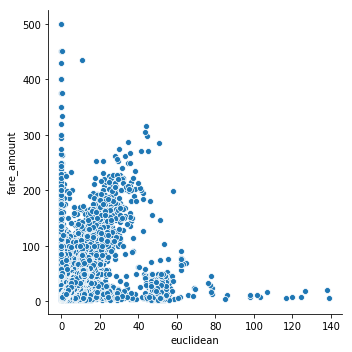

In [38]:
sb.relplot(x="euclidean", y="fare_amount", data=train_df);
plt.show()

From plot we try to cut off values. 
    - We see that for euclidean > 150 fare amount is close to zero only which is impossible intuitively. 
    - We see that for distance close to 0, fare_amount reaches 500, we try to cut it off at 350

In [61]:
train_df = train_df[(train_df['euclidean'] <= 150) ]
train_df = train_df[(train_df['fare_amount'] <= 350) ]
len(train_df)

929427

In [62]:
print (pearsonr(train_df['euclidean'] , train_df['fare_amount']))    

(0.8517711178638714, 0.0)


2) Time of day vs Distance traveled
    - Given column 'pickup_datetime' is a string, so we have to convert it into datetime format
    - Extract time of day (Not in terms of hour but in terms of seconds) 
    - Compare with Euclidean distance

In [63]:
import datetime
res = train_df.apply(lambda row: datetime.datetime.strptime(row['pickup_datetime'], "%Y-%m-%d %H:%M:%S %Z"), axis=1)
train_df = train_df.assign(pickup_datetime = res.values)

In [64]:
time = train_df.apply(lambda row: ((row['pickup_datetime'].hour*60*60) + (row['pickup_datetime'].minute*60) + (row['pickup_datetime'].second)), axis = 1)
train_df = train_df.assign(time = time.values)

In [65]:
print (pearsonr(train_df['euclidean'] , train_df['time']))

(-0.02789180537636574, 2.526996076584748e-159)


3)  Time of day vs Taxi fare
    - Compare as above

In [45]:
print (pearsonr(train_df['fare_amount'] , train_df['time']))

(-0.017460850610905774, 0.0)


The Pearson correlation of the above three comparisons are:
    1) Euclidean distance of the ride vs Taxi fare: 0.7823848626099872 (Highly correlated)
    2) Time of day vs Distance travelled: -0.025729621971280942 (Not correlated)
    3) Time of day vs Fare Amount: -0.017458907381592163 (Not correlated)
Thus, the highest correlation is between Euclidean distance vs Taxi Fare

TASK 3: VISUALIZING RELATION BETWEEN ABOVE PAIRS OF VARIABLES

1) Euclidean distance vs Fare amount

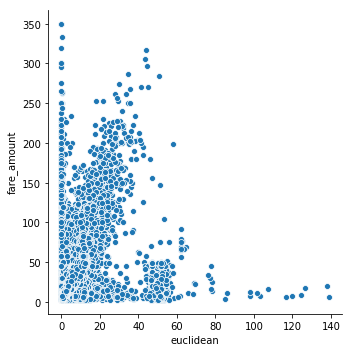

In [46]:
sb.relplot(x="euclidean", y="fare_amount", data=train_df);
plt.show()

2) Time of Day vs Euclidean distance

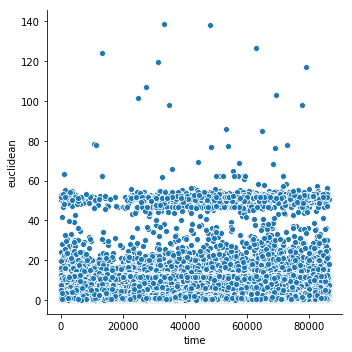

In [47]:
sb.relplot(x="time", y="euclidean", data=train_df);
plt.show()

3) Time of Day vs Fare Amount

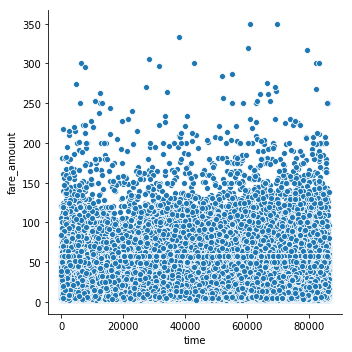

In [48]:
sb.relplot(x="time", y="fare_amount", data=train_df);
plt.show()

Comment about above visualisations:

1) Euclidean distance vs Taxi Fare:
        - The high correlation between Euclidean distance and Taxi fare is obvious from the graph. A clear linear relation is seen in the graph. 
        - The taxi fare increases as the euclidean distance increases, thus explaining the positive correlation between the two attributes.
        
2) Time of day vs Euclidean distance:
        - We can see that the data points are randomly scattered throughout the graph. Thus, there is no true relationship between the time of the day and the Euclidean distance, explaining why there is no correlation between the two attributes (correlation is very small and insignificant).
        - There are two clear horizontal lines in the visualization. It is likely that these lines signify trips from airports which have a fixed rate and high amount of traffic. We observe that most people arrive or depart from the airport in a time period from
        
3) Time of day vs Fare amount
        - We can see that the data points are randomly scattered throughout the graph. Thus, there is no true relationship between the time of the day and the Euclidean distance, explaining why there is no correlation between the two attributes (correlation is very small and insignificant).

We create a few additional features to add to the model:
- Haversine Distance : haversine
    - Haversine distance or 'as the crow flies' determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Since it takes the spherical shape of the Earth into account while estimating distance, it is taken as an attribute to hopefully get a more accurate distance measure.
- Rush hour : is_rush_hour
     - There is a 1\$ surcharge on the taxi fare during rush hour. Rush hour is defined as 4pm to 8pm on weekdays. Therefore, we create a boolean attribute that indicates whether the trip occured in the rush hour period or not.
- Night trip charge : is\_night
     - There is a 0.50\$ surcharge on the taxi fare for a night trip. A night trip is defined as a trip that takes place from 8 pm to 6 am. Therefore, we create a boolean attribute that indicates whether the trip is a night trip or not.
- JFK airport: is\_JFK
     - There is a flat fare of \$52 for all trips originating and culminating at JFK airport. This flat price was \$45 before 2012. In addition, there is a flat fare of \$4.50 for all trips that occur during rush hour. Therefore, I defined a four-point bounding box manually using Google Maps to locate coordinates. The coordinates are:  upper = 40.664, lower = 40.626, left = -74.192, right = -74.163. So, we create a boolean attribute that indicates if the origin/destination is JFK Airport.
- Newark airport: is\_newark
     - There is a \$17.50 surcharge on taxi fares to and from Newark Airport in addition to the metered fare. Therefore, I defined a four-point bounding box manually using Google Maps to locate coordinates. The coordinates are: upper = 40.717, lower = 40.665, left = -74.192 and right = -74.163. This is used to create a boolean attribute to indicate if the origin/destination is Newark Airport. 
- Estimated fare in miles : est_fare
     - The fare of a taxi is a function of the waiting time, the distance in miles travelled by the car on its journey and other surcharges. Since we have not been given the dropoff time, it is difficult to estimate the total duration of the journey. However, we try to define the fare based on the surcharges and distance as of now. The base fare is \$2.50.      
- Grid distance: grid\_distance
    - Manhattan has a grid-like structure so I expect a more accurate measure of distance would be the Manhattan distance such that it is the sum of the absolute distance between two sets of coordinates. I look to experiment with different distance measures to see which one works best for our problem.
- Day of the week, Hour of the day and Year: day\_of\_week, hour\_of\_day and year
    - I decided to extract data from the timestamp that intuitively felt the most important for prediction. The first two attributes relate to traffic - there could be more traffic during certain hours of the day and certain days of the week resulting in a higher fare. I added the year attribute as research revealed that there was a change (increase) in pricing of the taxi fares in 2012.
    

1) Haversine distance

In [66]:
res = train_df.apply(lambda row: haversine((row['pickup_latitude'] , row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']), miles = True), axis=1)
train_df = train_df.assign(haversine = res.values)

In [67]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine
0,2013-11-10 01:12:19.0000002,25.5,2013-11-10 01:12:19,-73.974497,40.751603,-73.934927,40.851567,4,4.965112,4339,7.210249
1,2012-11-06 11:33:14.0000004,9.5,2012-11-06 11:33:14,-73.972195,40.765883,-73.967942,40.761951,1,0.284610,41594,0.351203
2,2012-08-28 12:29:40.0000002,14.9,2012-08-28 12:29:40,-73.992214,40.758864,-73.993800,40.722718,1,1.632042,44980,2.498826
3,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00,-73.955268,40.782767,-73.932382,40.794812,6,1.314878,41280,1.458057
4,2010-01-17 22:07:00.00000098,5.7,2010-01-17 22:07:00,-73.967598,40.756242,-73.953277,40.768330,1,0.926858,79620,1.122163


2) Rush Hour
    Rush hour is defined as 4pm to 8pm on weekdays

In [68]:
def rush_hour(hr,wkd):
    if ((hr >= 16) & (hr <20) & (wkd<5)):
        return 1
    return 0

In [69]:
res = train_df.apply(lambda row: rush_hour(row['pickup_datetime'].hour, row['pickup_datetime'].weekday()), axis = 1)
train_df = train_df.assign(is_rush_hour = res.values)

In [70]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour
0,2013-11-10 01:12:19.0000002,25.5,2013-11-10 01:12:19,-73.974497,40.751603,-73.934927,40.851567,4,4.965112,4339,7.210249,0
1,2012-11-06 11:33:14.0000004,9.5,2012-11-06 11:33:14,-73.972195,40.765883,-73.967942,40.761951,1,0.284610,41594,0.351203,0
2,2012-08-28 12:29:40.0000002,14.9,2012-08-28 12:29:40,-73.992214,40.758864,-73.993800,40.722718,1,1.632042,44980,2.498826,0
3,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00,-73.955268,40.782767,-73.932382,40.794812,6,1.314878,41280,1.458057,0
4,2010-01-17 22:07:00.00000098,5.7,2010-01-17 22:07:00,-73.967598,40.756242,-73.953277,40.768330,1,0.926858,79620,1.122163,0


3) Night charge
    Night is defined as 8pm to 6am 

In [71]:
def is_night(hr):
    if ((hr>= 20) & (hr <24)):
        return 1
    elif ((hr>= 0) & (hr <6)):
        return 1
    else: 
        return 0

In [72]:
res = train_df.apply(lambda row: is_night(row['pickup_datetime'].hour), axis = 1)
train_df = train_df.assign(is_night = res.values)

In [73]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour,is_night
0,2013-11-10 01:12:19.0000002,25.5,2013-11-10 01:12:19,-73.974497,40.751603,-73.934927,40.851567,4,4.965112,4339,7.210249,0,1
1,2012-11-06 11:33:14.0000004,9.5,2012-11-06 11:33:14,-73.972195,40.765883,-73.967942,40.761951,1,0.284610,41594,0.351203,0,0
2,2012-08-28 12:29:40.0000002,14.9,2012-08-28 12:29:40,-73.992214,40.758864,-73.993800,40.722718,1,1.632042,44980,2.498826,0,0
3,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00,-73.955268,40.782767,-73.932382,40.794812,6,1.314878,41280,1.458057,0,0
4,2010-01-17 22:07:00.00000098,5.7,2010-01-17 22:07:00,-73.967598,40.756242,-73.953277,40.768330,1,0.926858,79620,1.122163,0,1


4) JFK: By looking at Google maps, we define JFK in a bounded box where upper = 40.664, lower = 40.626, left = -74.192, right = -74.163

In [74]:
def is_jfk(p_lat, p_long, d_lat, d_long):
    if((p_lat <= 40.664) & (p_lat >= 40.626)):
        if((p_long >= -73.82) & (p_long <= -73.77)):
            return 1
    
    if ((d_lat <= 40.664) & (d_lat >= 40.626)):
        if((d_long >= -73.82) & (d_long <=-73.77)):
            return 1
    
    return 0
                    

In [75]:
res = train_df.apply(lambda row: is_jfk(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
train_df = train_df.assign(is_jfk = res.values)

In [59]:
train_df.loc[train_df['is_jfk'] == 1]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour,is_night,is_jfk
48,2011-04-18 11:58:00.00000010,49.80,2011-04-18 11:58:00,-73.972822,40.793295,-73.782862,40.643950,2,12.011154,43080,14.332933,0,0,1
52,2012-02-17 08:14:00.000000194,49.80,2012-02-17 08:14:00,-73.788127,40.647295,-73.978957,40.756305,5,11.137336,29640,12.515773,0,0,1
91,2009-04-10 16:05:00.000000135,49.15,2009-04-10 16:05:00,-73.789652,40.643633,-73.987165,40.768555,1,11.777503,57900,13.472990,1,0,1
110,2012-01-30 05:04:19.0000001,49.80,2012-01-30 05:04:19,-73.987223,40.765566,-73.776534,40.645010,1,12.300019,18259,13.826174,0,1,1
179,2014-02-10 21:10:09.0000006,57.33,2014-02-10 21:10:09,-73.789298,40.646427,-73.988502,40.739490,2,11.246430,76209,12.257702,0,1,1
203,2013-12-23 21:51:01.0000002,43.50,2013-12-23 21:51:01,-73.789774,40.643895,-73.928265,40.763598,4,9.039515,78661,11.001133,0,1,1
244,2012-08-31 16:42:00.000000142,49.80,2012-08-31 16:42:00,-73.780022,40.647177,-73.976485,40.746387,1,11.220306,60120,12.365473,1,0,1
296,2010-01-31 20:57:00.00000053,30.50,2010-01-31 20:57:00,-73.790260,40.644085,-73.805295,40.750967,1,4.879377,75420,7.426710,0,1,1
394,2011-05-19 13:28:17.0000003,24.90,2011-05-19 13:28:17,-73.789230,40.646622,-73.725032,40.614140,0,3.669872,48497,4.045865,0,0,1
419,2012-08-19 12:08:36.0000001,49.80,2012-08-19 12:08:36,-73.777033,40.645357,-73.950470,40.777600,1,10.863972,43716,12.883902,0,0,1


5) Newark Airport: By looking at Google maps, we define Newark airport in a bounded box where upper = 40.717, lower = 40.665, left = -74.192 and right = -74.163

In [76]:
def is_newark(p_lat, p_long, d_lat, d_long):
    if((p_lat <= 40.717) & (p_lat >= 40.665)):
        if((p_long >= -74.192) & (p_long <= -74.163)):
            return 1
    
    if ((d_lat <= 40.717) & (d_lat >= 40.665)):
        if((d_long >= -74.192) & (d_long <=-74.163)):
            return 1
    
    return 0

In [77]:
res = train_df.apply(lambda row: is_newark(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
train_df = train_df.assign(is_newark = res.values)

In [62]:
train_df.loc[train_df['is_newark'] == 1]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour,is_night,is_jfk,is_newark
239,2013-10-03 09:01:36.0000004,79.00,2013-10-03 09:01:36,-73.985281,40.752603,-74.176925,40.694843,1,10.367381,32496,10.799551,0,0,0,1
1319,2011-12-16 14:38:00.00000042,82.50,2011-12-16 14:38:00,-73.979067,40.782127,-74.177755,40.690252,1,11.196530,52680,12.185989,0,0,0,1
1826,2013-05-28 04:44:00.0000001,80.35,2013-05-28 04:44:00,-73.979408,40.746637,-74.177393,40.695172,1,10.623947,17040,10.960443,0,1,0,1
3421,2012-09-30 13:50:00.000000185,91.00,2012-09-30 13:50:00,-73.951070,40.770610,-74.177735,40.690377,5,12.406722,49800,13.098624,0,0,0,1
4502,2009-04-14 06:18:00.00000026,60.30,2009-04-14 06:18:00,-73.965240,40.754100,-74.177453,40.690658,1,11.474466,22680,11.945704,0,0,0,1
4656,2013-11-06 15:50:04.0000002,68.00,2013-11-06 15:50:04,-73.989043,40.736657,-74.177378,40.695232,1,10.038154,57004,10.269903,0,0,0,1
5594,2013-12-07 11:22:00.000000179,79.00,2013-12-07 11:22:00,-73.999902,40.737760,-74.176675,40.693740,1,9.467737,40920,9.744360,0,0,0,1
6437,2009-08-03 07:25:32.0000002,79.00,2009-08-03 07:25:32,-74.178106,40.695566,-74.178111,40.695587,1,0.000982,26732,0.001474,0,0,0,1
6807,2014-07-28 16:26:58.0000001,78.00,2014-07-28 16:26:58,-74.181679,40.687739,-74.181558,40.687747,1,0.006350,59218,0.006363,1,0,0,1
7541,2014-02-03 04:59:32.0000001,58.50,2014-02-03 04:59:32,-73.978393,40.748020,-74.183083,40.687965,1,11.055648,17972,11.494266,0,1,0,1


Estimated fare: We try to estimate a fare for the taxi (assuming no waiting time) and see the results.

In [78]:
def est_fare(hav, rush, night, jfk, nwrk, year ):
    if (jfk):
        if (year >= 2012):
            if(rush):
                return 56.5
            else:
                return 52
        else:
            if(rush):
                return 49.5
            else:
                return 45
    
    else:
        fare = 2.5
        fare = fare + 0.5*(hav/0.2)
        if (rush):
            fare = fare + 1
        if (night):
            fare = fare + 0.5
        if (nwrk):
            fare = fare + 17.5
        return fare

In [79]:
res = train_df.apply(lambda row: est_fare(row['haversine'], row['is_rush_hour'], row['is_night'], row['is_jfk'], row['is_newark'], row['pickup_datetime'].year), axis = 1)
train_df = train_df.assign(est_fare = res.values)

In [65]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour,is_night,is_jfk,is_newark,est_fare
0,2012-04-08 07:30:50.0000002,5.3,2012-04-08 07:30:50,-73.996335,40.737142,-73.980721,40.733559,1,0.833269,27050,0.854122,0,0,0,0,4.635306
1,2013-02-12 12:15:46.0000002,11.5,2013-02-12 12:15:46,-73.957954,40.779252,-73.961250,40.758787,1,0.939324,44146,1.424474,0,0,0,0,6.061186
2,2009-01-09 16:10:00.000000170,31.9,2009-01-09 16:10:00,-73.873027,40.773883,-73.984545,40.769545,3,5.838524,58200,5.842935,1,0,0,0,18.107338
3,2009-06-10 21:28:00.00000022,12.1,2009-06-10 21:28:00,-73.988558,40.737200,-73.958688,40.780748,1,2.510533,77280,3.390741,0,1,0,0,11.476853
4,2013-11-10 01:12:19.0000002,25.5,2013-11-10 01:12:19,-73.974497,40.751603,-73.934927,40.851567,4,4.965112,4339,7.210249,0,1,0,0,21.025622


In [80]:
def grid_dist(p_lat, p_long,d_lat,d_long):
    x1 = 6371*math.cos(math.radians(p_lat))*math.cos(math.radians(p_long))
    y1 = 6371*math.cos(math.radians(p_lat))*math.sin(math.radians(p_long))
    x2 = 6371*math.cos(math.radians(d_lat))*math.cos(math.radians(d_long))
    y2 = 6371*math.cos(math.radians(d_lat))*math.sin(math.radians(d_long))
    return ((abs(x1-x2) + abs(y1-y2))*0.621371) 

In [81]:
res = train_df.apply(lambda row: grid_dist(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'] ), axis = 1 )
train_df = train_df.assign(grid_dist = res.values)

In [82]:
res = train_df.apply(lambda row: row['pickup_datetime'].weekday(), axis = 1 )
train_df = train_df.assign(day_of_week = res.values)

In [83]:
res = train_df.apply(lambda row: row['pickup_datetime'].hour, axis = 1 )
train_df = train_df.assign(hour_of_day = res.values)

In [84]:
res = train_df.apply(lambda row: row['pickup_datetime'].year, axis=1)
train_df = train_df.assign(year = res.values)

In [71]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean,time,haversine,is_rush_hour,is_night,is_jfk,is_newark,est_fare,grid_dist,day_of_week,hour_of_day,year
0,2012-04-08 07:30:50.0000002,5.3,2012-04-08 07:30:50,-73.996335,40.737142,-73.980721,40.733559,1,0.833269,27050,0.854122,0,0,0,0,4.635306,0.900503,6,7,2012
1,2013-02-12 12:15:46.0000002,11.5,2013-02-12 12:15:46,-73.957954,40.779252,-73.961250,40.758787,1,0.939324,44146,1.424474,0,0,0,0,6.061186,1.024441,1,12,2013
2,2009-01-09 16:10:00.000000170,31.9,2009-01-09 16:10:00,-73.873027,40.773883,-73.984545,40.769545,3,5.838524,58200,5.842935,1,0,0,0,18.107338,7.356472,4,16,2009
3,2009-06-10 21:28:00.00000022,12.1,2009-06-10 21:28:00,-73.988558,40.737200,-73.958688,40.780748,1,2.510533,77280,3.390741,0,1,0,0,11.476853,3.279835,2,21,2009
4,2013-11-10 01:12:19.0000002,25.5,2013-11-10 01:12:19,-73.974497,40.751603,-73.934927,40.851567,4,4.965112,4339,7.210249,0,1,0,0,21.025622,5.650954,6,1,2013


Visualizing few features:
    

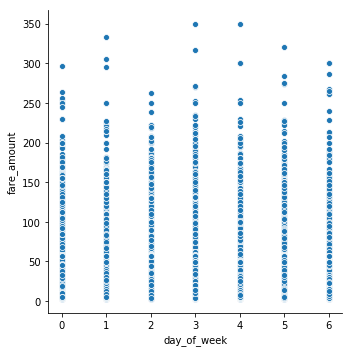

In [72]:
sb.relplot(x="day_of_week", y="fare_amount", data=train_df);
plt.show()

In [73]:
print (pearsonr(train_df['day_of_week'] , train_df['fare_amount']))

(0.0030504326887193308, 1.5919758911585874e-11)


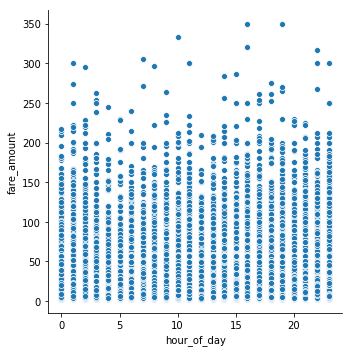

In [74]:
sb.relplot(x="hour_of_day", y="fare_amount", data=train_df);
plt.show()

In [75]:
print (pearsonr(train_df['hour_of_day'] , train_df['fare_amount']))

(-0.017144314260003984, 5.646834057e-314)


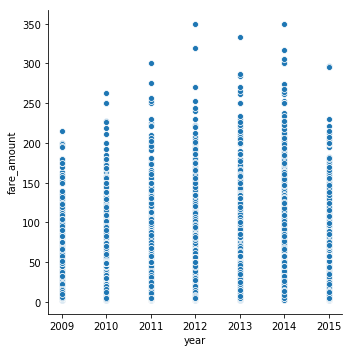

In [76]:
sb.relplot(x="year", y="fare_amount", data=train_df);
plt.show()

In [77]:
print (pearsonr(train_df['year'] , train_df['fare_amount']))

(0.11690512170889723, 0.0)


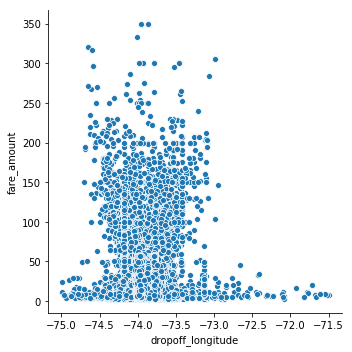

In [78]:
sb.relplot(x="dropoff_longitude", y="fare_amount", data=train_df);
plt.show()

In [79]:
print (pearsonr(train_df['dropoff_longitude'] , train_df['fare_amount']))

(0.3036409873548617, 0.0)


In [85]:
Y = train_df.apply(lambda row: row['fare_amount'], axis=1)
train_df, test_df, train_Y, test_Y = model_selection.train_test_split(train_df, Y, test_size=0.33, random_state=42)
train_df = train_df.drop(columns=['pickup_datetime','fare_amount'])
test_df = test_df.drop(columns=['pickup_datetime','fare_amount'])

In [86]:
lr = linear_model.LinearRegression()

In [87]:
le = LabelEncoder()
le.fit(train_df['key'].astype(str))
train_df['key'] = le.transform(train_df['key'].astype(str))
le.fit(test_df['key'].astype(str))
test_df['key'] = le.transform(test_df['key'].astype(str))
lr.fit(train_df, train_Y)
predictions = lr.predict(test_df)
mse = np.mean((test_Y-lr.predict(test_df))**2)

In [88]:
math.sqrt(mse)

4.769507319223128

In [89]:
lr.coef_

array([ 9.26206617e-06,  8.09980610e+00, -1.69898127e+01,  1.48673611e+01,
       -1.15331401e+01,  5.47525953e-02,  5.21628057e+00, -3.33550439e-05,
        8.30803691e-01, -4.14145989e-01, -1.06247996e+00, -5.73115168e+00,
       -1.42552636e-13,  2.15604529e-01, -2.46367874e+00, -2.75672832e-02,
        1.43636229e-01, -3.82334779e-01])

In [85]:
rf = RandomForestRegressor(n_estimators = 3, random_state = 42)
rf.fit(train_df, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [86]:
mse = np.mean((test_Y-rf.predict(test_df))**2)

In [87]:
print (mse)

19.61351217995099


In [88]:
rf.feature_importances_

array([3.75236980e-02, 1.91683757e-02, 1.67416144e-02, 3.97732946e-02,
       2.32533689e-02, 2.83341584e-03, 6.60394459e-01, 1.38413387e-02,
       3.13256552e-02, 2.92131157e-04, 3.31545351e-03, 2.84114645e-04,
       1.37759144e-05, 1.29118656e-01, 1.30940791e-02, 5.08973472e-03,
       2.60835499e-03, 1.32847968e-03])

In [90]:
train_df = train_df.drop(columns=['passenger_count','is_rush_hour','is_night','is_jfk','is_newark','grid_dist','day_of_week','hour_of_day','year'])
test_df = test_df.drop(columns=['passenger_count','is_rush_hour','is_night','is_jfk','is_newark','grid_dist','day_of_week','hour_of_day','year'])

In [91]:
rf = RandomForestRegressor()
rf.fit(train_df, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [92]:
mse = np.mean((test_Y-rf.predict(test_df))**2)

In [93]:
print(mse)

15.775128867628563


In [94]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.describe()

In [95]:
res = test_df.apply(lambda row: eucl(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'] ), axis = 1 )
test_df = test_df.assign(euclidean = res.values)

In [96]:
res = test_df.apply(lambda row: datetime.datetime.strptime(row['pickup_datetime'], "%Y-%m-%d %H:%M:%S %Z"), axis=1)
test_df = test_df.assign(pickup_datetime = res.values)
time = test_df.apply(lambda row: ((row['pickup_datetime'].hour*60*60) + (row['pickup_datetime'].minute*60) + (row['pickup_datetime'].second)), axis = 1)
test_df = test_df.assign(time = time.values)
res = test_df.apply(lambda row: haversine((row['pickup_latitude'] , row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']), miles = True), axis=1)
test_df = test_df.assign(haversine = res.values)
res = test_df.apply(lambda row: rush_hour(row['pickup_datetime'].hour, row['pickup_datetime'].weekday()), axis = 1)
test_df = test_df.assign(is_rush_hour = res.values)
res = test_df.apply(lambda row: is_night(row['pickup_datetime'].hour), axis = 1)
test_df = test_df.assign(is_night = res.values)
res = test_df.apply(lambda row: is_jfk(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
test_df = test_df.assign(is_jfk = res.values)
res = test_df.apply(lambda row: is_newark(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
test_df = test_df.assign(is_newark = res.values)
res = test_df.apply(lambda row: est_fare(row['haversine'], row['is_rush_hour'], row['is_night'], row['is_jfk'], row['is_newark'], row['pickup_datetime'].year), axis = 1)
test_df = test_df.assign(est_fare = res.values)

In [97]:
test_df = test_df.drop(columns=['pickup_datetime','passenger_count','is_rush_hour','is_night','is_jfk','is_newark'])

In [96]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidean,time,haversine,est_fare
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.719730,50272.227154,2.134640,8.663875
std,0.042774,0.033541,0.039072,0.035435,2.134913,24678.393767,2.468318,8.119551
min,-74.252193,40.573143,-74.263242,40.568973,0.000000,3.000000,0.000000,2.500000
25%,-73.992501,40.736125,-73.991247,40.735254,0.644796,30773.000000,0.806712,4.886091
50%,-73.982326,40.753051,-73.980015,40.754065,1.086154,54146.000000,1.377835,6.326850
75%,-73.968013,40.767113,-73.964059,40.768757,1.935368,71464.000000,2.513633,9.233415
max,-72.986532,41.709555,-72.990963,41.696683,52.649987,86311.000000,62.134640,157.836599


In [98]:
keys = test_df['key']
le.fit(test_df['key'].astype(str))
test_df['key'] = le.transform(test_df['key'].astype(str))
predictions = rf.predict(test_df)

In [99]:
predic = pd.DataFrame({'key': keys, 'fare_amount': predictions})
predic.to_csv('submission.csv', index = False)

External datasets: 
    - One thing that was difficult to realize as a feature was the duration of the journey. Since the meter hikes up the price of the fare by $0.50 every minute, the duration of the journey would serve as an important feature for the model. One possible way of implementing this would be by finding data that already has the duration of the journey as an attribute and using imputation (with the help of regression possibly) to generate data points for duration of journey for our training dataset. The given training data is a subset of the data provided by the NYC TLC (Taxi and Limousine Commission) that has recorded taxi trip data from 2009 to 2018. (Source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). This data has additional features, one of which is 'dropoff_datetime'. Thus, we can calculate the journey duration using this additional data rows and impute the values for the ones in the training set.
    - The coordinates for the airports were retrieved manually by defining a four-point bounding box via Google Maps. Thus, it is an approximation of airport area. I found an online dataset that defined a polygon for airports in NY (Airport Polygon: https://data.cityofnewyork.us/City-Government/Airport-Polygon/xfhz-rhsk) that will give an accurate representation of drop-off/pickup points actually in the airport.
    - I originally pre-processed the data by defining a bounding box of the area where the taxi can travel. We could tighten the box, but the coordinates were difficult to retrieve manually via Google Maps. I found a dataset available online that defines the boundaries of the 5 boroughs via coordinate points (Borough Boundaries: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm). We can use this to pre-process the data so as to tighten it such that we cover only the main New York City area. This also helps remove coordinates from the dataset that are in the middle of the sea, that could not be removed via previous preprocessing methods.  
    - All of the distance measures we use are not the most accurate distance measures. Obstacles that may block the path of a vehicle are not accounted for. The most accurate measure of distance would be to use Google Map data to find the distance between two sets of coordinates. This however was not possible to implement as usage of the API required payment.
    